In [46]:
# %% Imports
from utils import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import shap
import pandas as pd

In [2]:
# %% Load and preprocess data
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()
# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)
print(X_train.shape)
print(X_test.shape)

(7778, 21)
(1022, 21)


In [3]:
# %% Fit blackbox model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

F1 Score 0.5483585858585859
Accuracy 0.9452054794520548


In [33]:
# %% Create SHAP explainer
explainer = shap.TreeExplainer(rf)
# Calculate shapley values for test data
start_index = 3
end_index = 4
shap_values = explainer.shap_values(X_test[start_index:end_index])
X_test[start_index:end_index]

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi
3133,True,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,16.0,0,0,87.16,28.2


In [34]:
# %% Investigating the values (classification problem)
# class 0 = contribution to class 1
# class 1 = contribution to class 2
print(shap_values[0].shape)
print(shap_values)


(21, 2)
[[[ 2.05493001e-05 -2.05493001e-05]
  [ 2.03938196e-03 -2.03938196e-03]
  [-4.86412329e-07  4.86412329e-07]
  [ 1.82947646e-02 -1.82947646e-02]
  [ 1.46108379e-02 -1.46108379e-02]
  [ 3.16006325e-03 -3.16006325e-03]
  [-9.83340037e-05  9.83340037e-05]
  [ 4.33167745e-03 -4.33167745e-03]
  [ 6.37964779e-03 -6.37964779e-03]
  [-2.35442014e-03  2.35442014e-03]
  [ 2.20658101e-03 -2.20658101e-03]
  [ 1.23391385e-03 -1.23391385e-03]
  [-3.90763465e-03  3.90763465e-03]
  [ 5.32874906e-03 -5.32874906e-03]
  [ 5.33193278e-03 -5.33193278e-03]
  [ 2.91472301e-03 -2.91472301e-03]
  [ 2.74576149e-01 -2.74576149e-01]
  [ 3.32318031e-02 -3.32318031e-02]
  [ 8.40566607e-03 -8.40566607e-03]
  [ 6.98058436e-02 -6.98058436e-02]
  [ 5.43265966e-02 -5.43265966e-02]]]


The RF predicted: 0


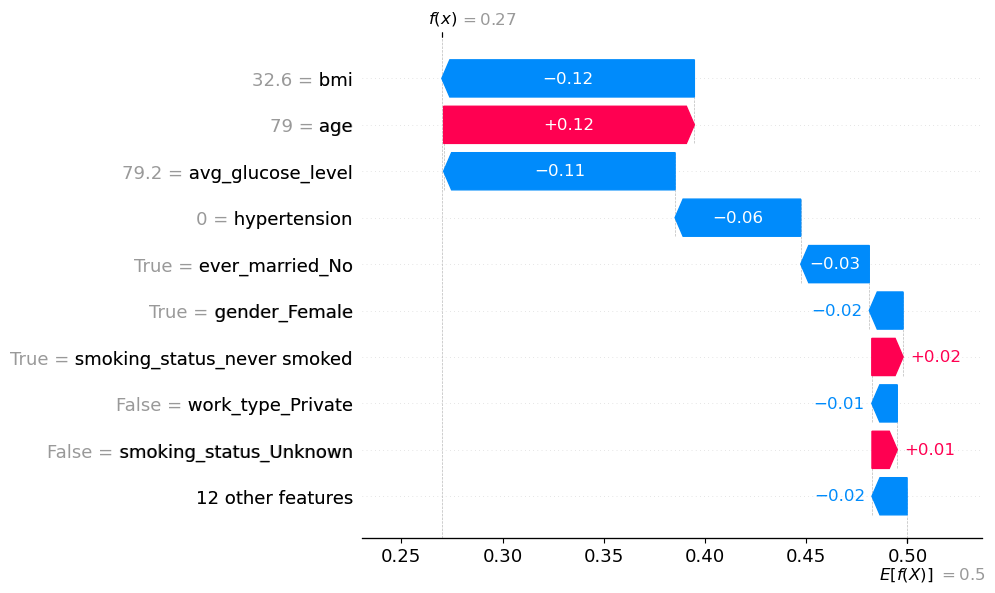

In [ ]:
sample_idx = 28 # no-stroke predicted
sample_idx = 13 # stroke predicted
interesting_cases = [28, 12, 76, 122]
shap_values = explainer.shap_values(X_test[sample_idx:sample_idx+1])
shap_single = shap_values[0, :, 1]  # SHAP values for class 1

# Grab sample values
if isinstance(X_test, pd.DataFrame):
    sample_data = X_test.iloc[sample_idx]
    feature_names = X_test.columns
else:
    sample_data = X_test[sample_idx]
    feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]

prediction = rf.predict(X_test[sample_idx:sample_idx+1])[0]
print(f"The RF predicted: {prediction}")

# Create SHAP explanation object
exp = shap.Explanation(
    values=shap_single,
    base_values=explainer.expected_value[1],
    data=sample_data,
    feature_names=feature_names
)


# Plot waterfall
shap.plots.waterfall(exp)

In [35]:
# %% >> Visualize local predictions
shap.initjs()
# Force plot
prediction = rf.predict(X_test[start_index:end_index])[0]
print(f"The RF predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[0,:,0],
                X_test[start_index:end_index]) # for values

The RF predicted: 0


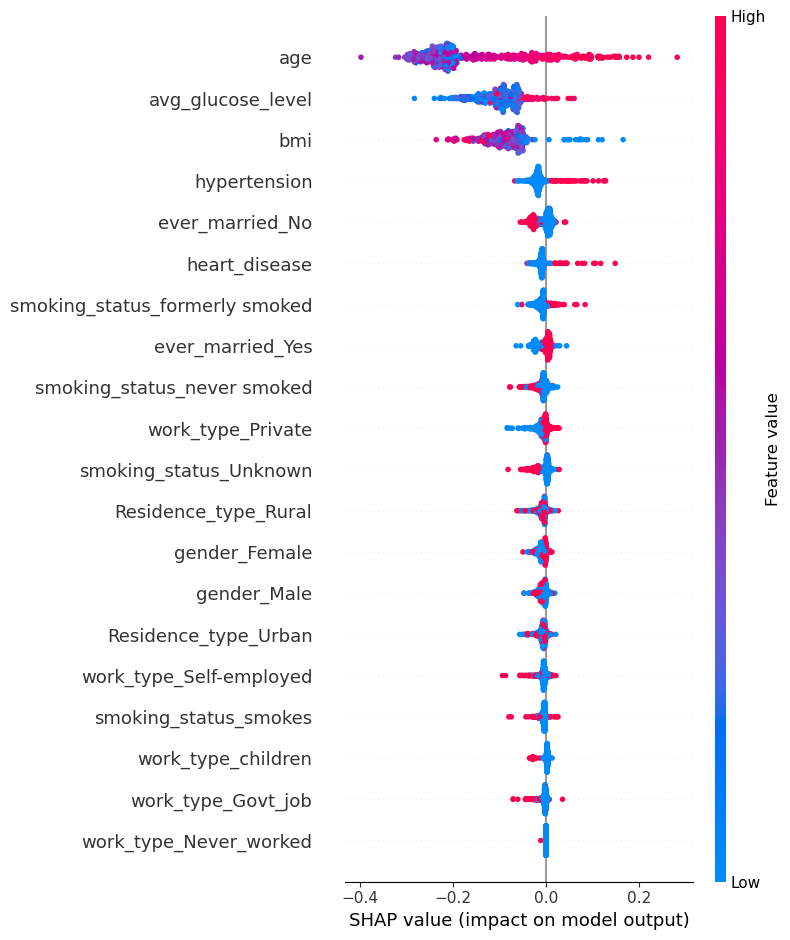

In [63]:
# %% >> Visualize global features
# Feature summary
#shap_values = explainer.shap_values(X_test[start_index:end_index])
shap_values = explainer.shap_values(X_test[:500])  # or X_test for all
shap.summary_plot(shap_values[:,:,1], X_test[:500])